In [1]:
import datetime as dt
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# data
DATA_PATH = os.path.join(os.pardir, 'data')
COUNTRY = 'CRO'
DATA = os.path.join(DATA_PATH, COUNTRY)
CONFIRMED_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'confirmed_cases.dat')
RECOVERED_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'recovered_cases.dat')
DEATH_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'death_cases.dat')
TESTS_PATH = os.path.join(DATA_PATH, COUNTRY, 'tests.dat')

confirmed_cases = np.loadtxt(CONFIRMED_CASES_PATH)
recovered_cases = np.loadtxt(RECOVERED_CASES_PATH)
death_cases = np.loadtxt(DEATH_CASES_PATH)
daily_tests = np.loadtxt(TESTS_PATH)

epidemics_start_date = dt.datetime(2020, 2, 25)
date_list = [epidemics_start_date + dt.timedelta(days=i) for i in range(confirmed_cases.size)]
# full data dataframe
df = pd.DataFrame({
    'date': date_list,
    'confirmed_cases': confirmed_cases,
    'recovered_cases': recovered_cases,
    'death_cases': death_cases,
    'daily_tests': daily_tests})

Unfortunatelly, there is no confirmed value of sensitivity and specificity for tests in Croatia (different hospitals) use different tests. Ideal case is when both sensitivity and specificity are 1 (no false classifications). Realistic case is to expect high value of specificity and sensitivity between 72% and 98% [1](https://www.bmj.com/content/bmj/369/bmj.m1808.full.pdf). Since this simulator takes worse case scenario into an account (95% CI lower bound for sensitivity and upper bound for specificity), the simulation performed here uses sensitivity with expected value of 85% (for 95% CI range between 80.75% and 89.25%, where lower value is taken into an  account) and specificity with expected value of 95% (for 95% CI range between 90.25% and 99.75%, where upper value is taken into an account).

Ref.
[1] BMJ 2020;369:m1808 

In [41]:
from coropy.growth_models import GrowthCOVIDModel, _logistic_func, _exp_func
from coropy.utils import normalize, restore
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit

In [59]:
eff_date = dt.datetime(2020, 6, 1)
df_critical = df[df.date < eff_date]
df_critical.reset_index(drop=True, inplace=True)

cumulative_positive = df_critical.confirmed_cases.values
daily_positive = np.concatenate((np.array([cumulative_positive[0]]), np.diff(cumulative_positive)))
cumulative_removed = df_critical.recovered_cases.values + df_critical.death_cases.values
daily_tests = df_critical.daily_tests.values

In [60]:
pcr_sens = 0.9
pcr_spec = 0.95

In [61]:
std_sens_err = np.sqrt(np.divide(
    (1 - pcr_sens) * pcr_sens, 
    daily_positive, 
    out=np.zeros(daily_positive.shape, dtype=float), 
    where=daily_positive!=0,))
sens_lb_ci = pcr_sens - 1.96 * std_sens_err
tp_lb_ci = sens_lb_ci * daily_positive
cumulative_tp_lb_ci = np.cumsum(tp_lb_ci)

daily_tests = np.concatenate((np.array([daily_tests[0]]),
    daily_tests[:-1]))
daily_negative = daily_tests - daily_positive
std_spec_err = np.sqrt(np.divide(
    (1 - pcr_spec) * pcr_spec,
    daily_negative,
    out=np.zeros(daily_negative.shape, dtype=float), 
    where=daily_negative!=0,))
spec_ub_ci = pcr_spec - 1.96 * std_spec_err
tn_ci = spec_ub_ci * daily_negative
fn_ci = daily_negative - tn_ci
tp_ub_ci = fn_ci + daily_positive
cumulative_tp_ub_ci = np.cumsum(tp_ub_ci)

In [62]:
y_data_disp = np.asarray([np.random.uniform(cumulative_tp_lb_ci[i], cumulative_tp_ub_ci[i], 100) for i in range(cumulative_positive.size)])

In [63]:
y_data_stds = y_data_disp.std(axis=1)

In [64]:
scaler = MinMaxScaler()
y = scaler.fit_transform(cumulative_positive.reshape(-1, 1))
y_spread = scaler.transform(y_data_stds.reshape(-1, 1))
x = normalize(np.arange(cumulative_positive.size))

In [84]:
popt, pcov = curve_fit(_logistic_func, x, y.ravel(),sigma=y_spread.ravel(), absolute_sigma=True)
fitted = _logistic_func(x, *popt)

In [85]:
perr = np.sqrt(np.diag(pcov))
lower_bound = _logistic_func(x, *(popt)) + y_spread.ravel()
upper_bound = _logistic_func(x, *(popt)) - y_spread.ravel()

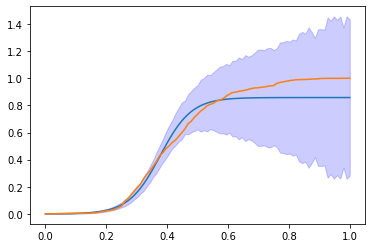

In [86]:
plt.plot(x, fitted)
plt.fill_between(x, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.plot(x, y)